# GGH Cryptanalysis
A demo of the GGH cryptanalysis by Nguyen. For illustration purposes we limit the dimension of the lattice to 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix
from ggh.signature import generate_keypair, LatticeBasis
from ggh.attack import generate_pairs, gradient_descent, simulate_attack

# Fix seeding for reproducible results
np.random.seed(999)

lattice_dim = 2
pk, sk = generate_keypair(lattice_dim)
print(f"ortho-defect of sk is {sk.ortho_defect}")
display(sk.to_sympy_matrix())
print(f"ortho-defect of pk is {pk.ortho_defect}")
display(pk.to_sympy_matrix())


sample_pairs = generate_pairs(10000, sk)
samples = [(sigma - m) * 2 for (m, sigma) in sample_pairs]

ortho-defect of sk is 1.0003740339937717


Matrix([
[293,  -8],
[  1, 260]])

ortho-defect of pk is 293.0017064796722


Matrix([
[76188, 293],
[    0,   1]])

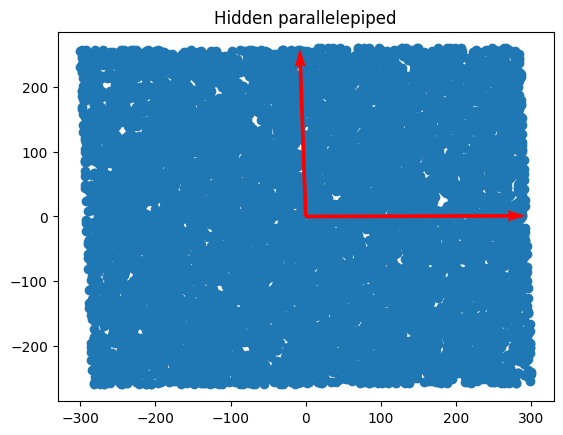

In [2]:
# Visualize the hidden parallelepiped
sample_xs = [sample[0] for sample in samples]
sample_ys = [sample[1] for sample in samples]

hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("Hidden parallelepiped")
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for base_vector in sk.iter_base_vectors():
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(0, 0, x, y, color="red", angles='xy', scale_units='xy', scale=1)

plt.show()

# Estimate the covariance matrix

Given a parallelepiped defined by $\mathcal{P}(V) = \{V\mathbf{x} \mid \mathbf{x} \in [-1, 1]^n \}$, and some uniformly sampled $\mathbf{v} \leftarrow \mathcal{P}(V)$:

$$
\exp[\mathbf{v}^\intercal\mathbf{v}] = V^\intercal V
$$

This means that we can use the samples $\{\mathbf{m}_i - \mathbf{\sigma}_i\}_{i \in S}$ to approximate the convariance matrix

In [3]:
samples_sym = Matrix(np.array(samples).astype(int))
approx_covariance = (
    samples_sym.transpose() * samples_sym / samples_sym.shape[0] * 3
)
true_covariance = Matrix(
    sk.to_sympy_matrix() * sk.to_sympy_matrix().transpose()
)

print(f"The estimated covariance is:")
display(approx_covariance.evalf())
print(f"The true covariance is:")
display(true_covariance)

The estimated covariance is:


Matrix([
[84502.5696, -1843.0716],
[-1843.0716, 67736.5836]])

The true covariance is:


Matrix([
[85913, -1787],
[-1787, 67601]])

# Hypercube transformation

Now that we have approximated the covariance matrix, we can transform the parallelepiped into the hypercube:

1. Compute $G^{-1}$ where $G$ is the approximated covariance matrix
2. Compute $L$ the Cholesky factor of $G^{-1}$ (the unique lower-triangular matrix such that $G^{-1} = LL^\intercal$).
3. Compute $C = VL$ where $V$ is the basis of the hidden parallelepiped

Then:

- $C$ is pairwise orthogonal unit vectors
- If $\mathbf{v}$ is uniformly distributed over the parallelepiped, then $\mathbf{c} = \mathbf{v}L$ is uniformly distributed over the hypercube $\mathcal{P}(C)$

The true hypercube basis is


Matrix([
[ 0.999180701038963, -0.0307690031886879],
[0.0268675999601096,   0.999992603632356]])

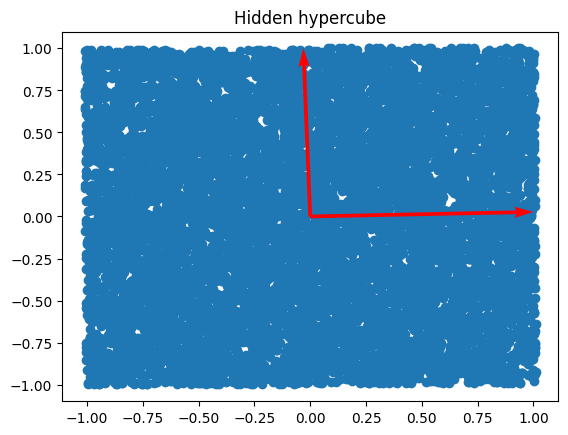

In [4]:
approx_cholesky = approx_covariance.inv().cholesky(hermitian=False)
true_cholesky = true_covariance.inv().cholesky(hermitian=False)
cube_samples_sym = samples_sym * approx_cholesky
cube_samples = np.array(cube_samples_sym.evalf()).astype(float)
cube_basis = sk.to_sympy_matrix() * true_cholesky

print("The true hypercube basis is")
display(cube_basis.evalf())
cube_basis = np.array(cube_basis).astype(float)

cube_fig, cube_ax = plt.subplots()
cube_ax.set_title("Hidden hypercube")
cube_ax.scatter(x=cube_samples_sym[:, 0], y=cube_samples_sym[:, 1])
for base_vector in LatticeBasis(cube_basis).iter_base_vectors():
    x, y = base_vector[0], base_vector[1]
    cube_ax.quiver(0, 0, x, y, color="red", angles='xy', scale_units='xy', scale=1)

plt.show()

# Learning the hypercube using gradient descent

The k-th moment of a parallelepipied $\mathcal{P}(V)$ over a vector $\mathbf{w}\in\mathbb{R}^n$ is defined by:

$$
\mathop{\text{mom}}_{V,k}(\mathbf{w}) = E[\langle \mathbf{u}, \mathbf{w}\rangle ^ k]
$$

where $\mathbf{u}$ is uniformly distributed over $\mathcal{P}(V)$

Nguyen showed that the global minimum of the fourth moment $\mathop{\text{mom}}_{V, 4}$ over the unit sphere is achieved at $\pm \mathbf{v}_i$ for $1 \leq i \leq n$ and there are no other local minima.

In other words, we can empirically search for the $\mathbf{w} \in \mathbb{R}^n$ that minimizes the fourth moment, and the result should be a close approximation of one of the basis of the hypercube, which we denote by $\mathbf{c}$.

Since $C = VL$, we can recover the basis of the hidden parallelepiped $\mathbf{v} = \mathbf{c}L^{-1}$

## Empirical computation
We can approximate the k-th moment and its gradient using the samples:

$$
\mathop{\text{mom}}_{V,k}(\mathbf{w}) \approx \frac{1}{n}\sum_{\mathbf{u} \in S} (\mathbf{u}^\intercal\mathbf{w})^k
$$

$$
\frac{\partial}{\partial\mathbf{w}}
\bigg\lbrack
    \mathop{\text{mom}}_{V,k}(\mathbf{w})
\bigg\rbrack
\approx \frac{k}{n}
\sum_{\mathbf{u} \in S} \bigg(
(\mathbf{u}^\intercal\mathbf{w})^{k-1}\mathbf{u}
\bigg)
$$

In [5]:
approx_secret_basis = []
for w_init in np.eye(lattice_dim):
    approx_cube_base = gradient_descent(cube_samples, 0.1, w_init)
    v = np.array(
        approx_cholesky.evalf().inv().transpose(), dtype=float
    ).dot(approx_cube_base)
    approx_secret_basis.append(np.round(v))
approx_secret_basis = LatticeBasis(np.array(approx_secret_basis).transpose())

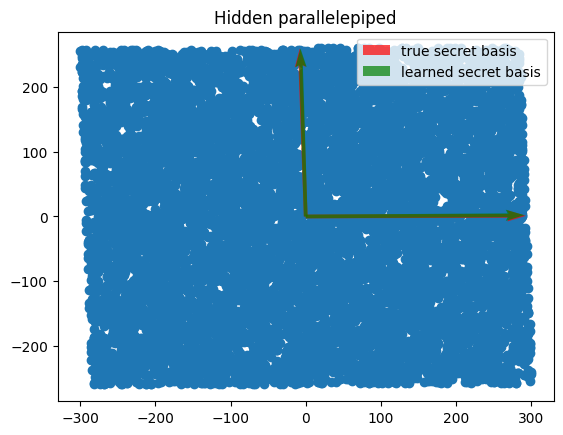

In [6]:
# Visualize the recovered basis against the true basis
hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("Hidden parallelepiped")
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for i, base_vector in enumerate(sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="true secret basis" if i == 0 else None,
        color="red", alpha=0.7
    )
for i, base_vector in enumerate(approx_secret_basis.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="learned secret basis" if i == 0 else None,
        color="green", alpha=0.7
    )

plt.legend()
plt.show()

# Trying the cryptanalysis for higher dimensions


Lattice dimension at n=14, sample size 10000
True secret basis is:


Matrix([
[598,  67,   7,  83,  31,  14,  -19,  75, -70,  -4,  88,   5,  56,  43],
[-40, 494, -60, -22, -50,  78,  -12,  13, -43, -20, -13,  88,  28,  24],
[-33,  45, 446, -81, -14,  27,   88,   8, -51,  33, -13,  84, -88, -30],
[-15,   8, -44, 567, -60, -23,   -9, -44, -53,  66,  51,  88,  95,  44],
[ 73, -63, -79,  37, 443,  16,   53,  71, -96, -22,  21,  61,   9,  72],
[ 97, -66,  55,  50, -40, 530,   63,  42,  42, -38,  32,  23,  40,  -9],
[ 83, -66,  80, -56, -89, -73,  517,  93, -84, -26, -24, -37,  76, -63],
[ 32,  22, -12, -81, -21,  72,  -54, 488, -35,  18,  60,  47, -42, -24],
[-73,   2, -11, -26, -88,  66,   15,  97, 449, -54, -80,  61,  52,  93],
[-68,  -6, -38,  66,  96, -50,   83,  99,  22, 445,   9,  24, -65,  77],
[-90, -81,  -6,   1,  86, -63,    7,  84, -62, -54, 418,  -7, -52, -54],
[-36,  56, -20,  88,  19, -53,   82,  25, -64, -57,  -1, 592, -72,  22],
[ 71,  37,  84, -51,  56,  52, -100, -60,  85, -71,  80,  71, 595, -36],
[ 55, -62, -29,  45,  23, -45,  -62, -21, 

Learned secret basis is:


Matrix([
[ 596,  71,  15,  84,  21,   9,  -20,  58,  -68,  13,  81,  -5,  59,  46],
[ -39, 491, -61, -23, -52,  81,  -23,  -1,  -51, -28, -11,  83,  27,  24],
[ -25,  45, 446, -75, -11,  31,   88,   8,  -51,  43, -11,  81, -94, -27],
[ -23,   6, -45, 564, -61, -26,  -15, -47,  -57,  56,  54,  85, 113,  55],
[  72, -65, -82,  30, 441,  14,   59,  61, -104, -13,  20,  54,   6,  84],
[  95, -63,  66,  42, -51, 526,   61,  40,   35, -37,  25,  23,  52,  12],
[  89, -69,  81, -54, -85, -68,  518,  89,  -86, -17, -30, -35,  72, -63],
[  28,  14, -11, -89, -32,  65,  -60, 489,  -39,  19,  62,  44, -52, -24],
[ -76,  -5,  -5, -30, -91,  68,   -1,  94,  449, -55, -78,  56,  50,  92],
[ -63, -13, -28,  60, 103, -51,   81, 106,   21, 442,  10,  11, -58,  83],
[-100, -78, -14,   1,  84, -71,    2,  89,  -66, -60, 423,  -4, -62, -48],
[ -39,  48, -28,  76,  17, -52,   74,  20,  -80, -56,   2, 590, -71,  32],
[  72,  37,  84, -43,  51,  62, -112, -83,   94, -67,  75,  72, 591, -31],
[  56, -69, -31,

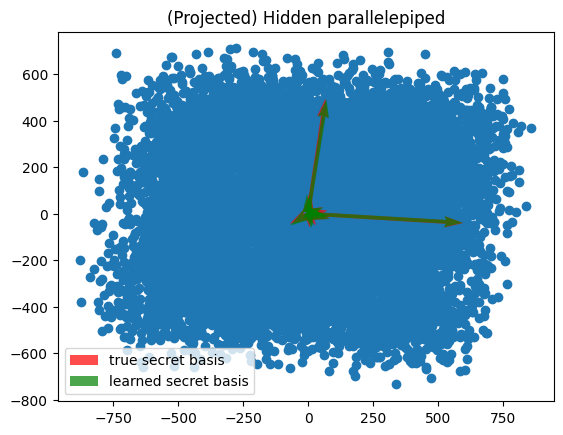

In [10]:
lattice_dim, sample_size = 14, 10000
sk, approx_sk, samples = simulate_attack(lattice_dim, sample_size)
print(f"Lattice dimension at n={lattice_dim}, sample size {sample_size}")
print(f"True secret basis is:"); display(sk.to_sympy_matrix())
print(f"Learned secret basis is:"); display(approx_sk.to_sympy_matrix())

hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("(Projected) Hidden parallelepiped")
sample_xs = [sample[0] for sample in samples]
sample_ys = [sample[1] for sample in samples]
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for i, base_vector in enumerate(sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="true secret basis" if i == 0 else None,
        color="red", alpha=0.7
    )
for i, base_vector in enumerate(approx_sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="learned secret basis" if i == 0 else None,
        color="green", alpha=0.7
    )

plt.legend()
plt.show()